In [1]:
from tops.config import instantiate, LazyConfig
from ssd import utils
from tqdm import tqdm
import numpy as np
import pandas as pd
from math import ceil

In [2]:
def get_config(config_path):
    cfg = LazyConfig.load(config_path)
    cfg.train.batch_size = 1
    return cfg


In [28]:
def get_dataloader(cfg, dataset_to_visualize):
    if dataset_to_visualize == "train":
        # Remove GroundTruthBoxesToAnchors transform
        cfg.data_train.dataset.transform.transforms = cfg.data_train.dataset.transform.transforms[:-1]
        data_loader = instantiate(cfg.data_train.dataloader)
    else:
        cfg.data_val.dataloader.collate_fn = utils.batch_collate
        data_loader = instantiate(cfg.data_val.dataloader)

    return data_loader

In [29]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def analyze_something(dataloader, cfg):
    label_count = Counter()
    dataset = pd.DataFrame(columns=['image_id','labels','boxes'])
    for batch in tqdm(dataloader):
        # Remove the two lines below and start analyzing :D
        labels = batch['labels'].tolist()
        boxes = batch['boxes'].tolist()
        image_id = batch['image_id'].tolist()
        dataset = dataset.append({'image_id': image_id[0], 'labels':labels[0],'boxes': boxes[0]},ignore_index=True)
        '''for labels in batch['labels']:
            label_count.update(labels.numpy())'''
    dataset.to_csv("dataset.csv")       
    print("Item counts "+str(label_count))

In [30]:

def main():
    config_path = "configs/tdt4265.py"
    cfg = get_config(config_path)
    dataset_to_analyze = "train"  # or "val"

    print("Label map is:", cfg.label_map)
    print(cfg.data_train)
    dataloader = get_dataloader(cfg, dataset_to_analyze)
    analyze_something(dataloader, cfg)
    
main()

It looks like you are currently working on the server, with a 'working directory' in: /work/snotra/lautaror
	If you struggle with NTNU home directory becoming full, we recommend you to change the output directory to: /work/snotra/lautaror
	 /work/snotra/lautaror does not sync with NTNU HOME, and is a directory only located on the server.
	 To change the output directory of SSD, set save_in_work to True in the file configs/utils.py, in the function get_output_dir.
Saving SSD outputs to: outputs/
Found dataset directory in: /work/datasets/mnist_object_detection/train
Found dataset directory in: /work/datasets/mnist_object_detection/val
Found dataset directory in: /work/datasets/tdt4265_2022
Found dataset file in: /work/datasets/tdt4265_2022/train_annotations.json
Found dataset directory in: /work/datasets/tdt4265_2022
Found dataset file in: /work/datasets/tdt4265_2022/val_annotations.json
Label map is: {0: 'background', 1: 'car', 2: 'truck', 3: 'bus', 4: 'motorcycle', 5: 'bicycle', 6: 's

100%|██████████████████████████████████████████████████████████████████████████████| 1604/1604 [00:14<00:00, 108.24it/s]


Item counts Counter()


In [31]:
import ast
data = pd.read_csv('dataset.csv',index_col=0)
data.boxes= data.boxes.apply(ast.literal_eval)
data.labels = data.labels.apply(ast.literal_eval)

In [27]:
data.sort_values(by=['image_id']).image_id

54       1
55       2
56       3
57       4
58       5
      ... 
216    297
217    298
218    299
219    300
220    301
Name: image_id, Length: 301, dtype: int64

In [7]:
box_list = []
label_list = []
for boxes,labels in zip(data.boxes,data.labels):
    box_list = box_list + boxes
    label_list = label_list + labels
boxes = pd.DataFrame(columns=['box','label','box_px','height','width','size','cluster'])
boxes.box=box_list
boxes.label=label_list

In [8]:
def box_to_pixels(box):
    return [int(box[0]*1024),int(box[1]*128),int(box[2]*1024),int(box[3]*128)]

def box_size(box):
    return (box[0]-box[2])*(box[1]-box[3])

def box_height(box):
    return (box[3]-box[1])
def box_width(box):
    return (box[2]-box[0])

In [9]:
boxes.box_px = boxes.box.apply(box_to_pixels)
boxes.height = boxes.box_px.apply(box_height)
boxes.width = boxes.box_px.apply(box_width)
boxes.size = boxes.box_px.apply(box_size)

In [10]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=6, random_state=0)
kmeans.fit(np.array([boxes.height,boxes.width]).T)
boxes.cluster = kmeans.predict(np.array([boxes.height,boxes.width]).T)

In [11]:
from sklearn.cluster import AgglomerativeClustering
boxes.cluster = AgglomerativeClustering(linkage='ward',n_clusters=6).fit_predict(np.array([boxes.height,boxes.width]).T)

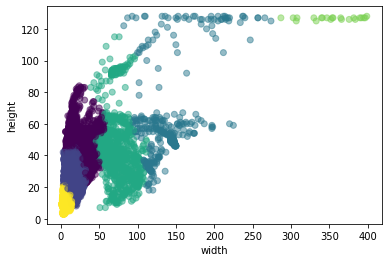

In [12]:
import numpy as np
import matplotlib.pyplot as plt

plt.scatter(boxes.width, boxes.height, c=boxes.cluster, alpha=0.5)
plt.xlabel('width')
plt.ylabel('height')
plt.show()

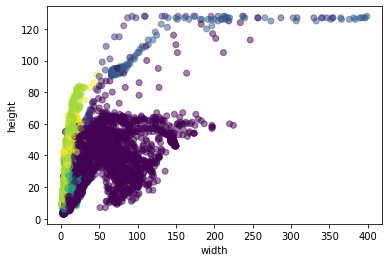

In [13]:
import numpy as np
import matplotlib.pyplot as plt

plt.scatter(boxes.width, boxes.height, c=boxes.label, alpha=0.5)
plt.xlabel('width')
plt.ylabel('height')
plt.show()

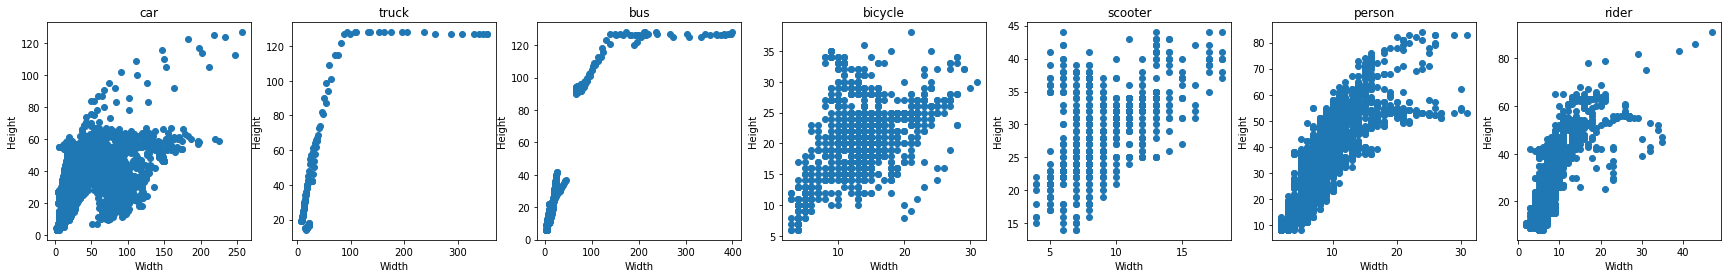

In [14]:
fig, axs = plt.subplots(1,7, figsize=[30,4])
tags = {0: 'background', 1: 'car', 2: 'truck', 3: 'bus', 4: 'motorcycle', 5: 'bicycle', 6: 'scooter', 7: 'person', 8: 'rider'}
for i,label in enumerate(np.sort(boxes.label.unique())):
    label_boxes = boxes[boxes.label == label]
    
    axs[i].scatter(label_boxes.width,label_boxes.height)
    axs[i].set_title(str(tags[label]),fontsize=12)
    axs[i].set_xlabel("Width")
    axs[i].set_ylabel("Height")

plt.show()


In [15]:
np.shape(np.array([label_boxes.width,label_boxes.height]).T)

(1588, 2)

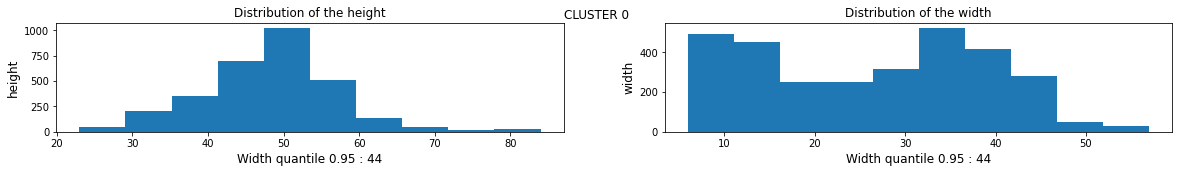

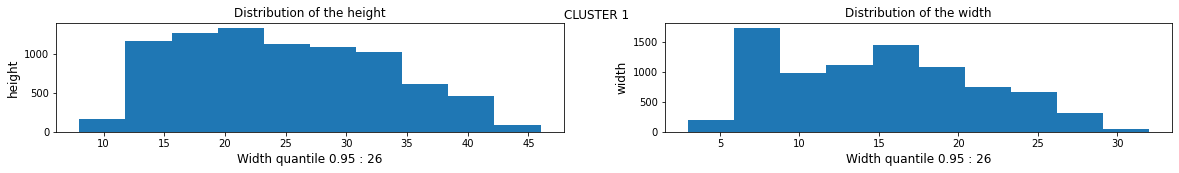

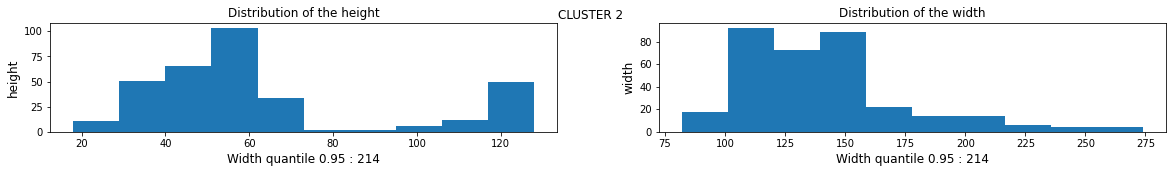

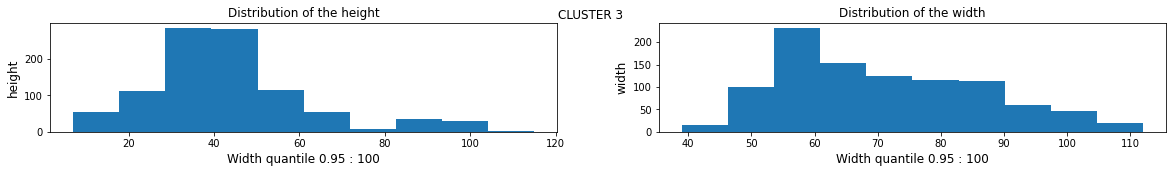

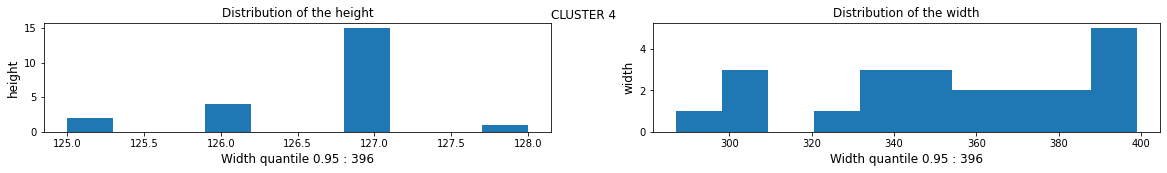

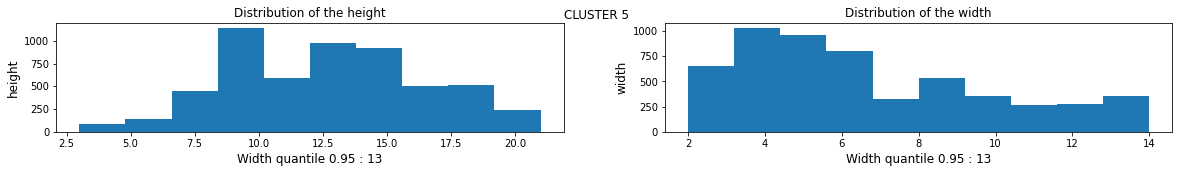

In [16]:
new_anchors = []
for cluster in np.sort(boxes.cluster.unique()):
    
    cluster_boxes = boxes[boxes.cluster == cluster]
    
    fig, axs = plt.subplots(1, 2, figsize=[20,2])
    fig.suptitle("CLUSTER "+str(cluster),fontsize=12)
    
    axs[1].hist(cluster_boxes['width'])
    axs[1].set_title('Distribution of the width',fontsize=12)
    axs[1].set_xlabel("Width quantile 0.95 : " + str(int(cluster_boxes['width'].quantile(q=0.95))),fontsize=12)
    axs[1].set_ylabel('width',fontsize=12)
    
    axs[0].hist(cluster_boxes['height'])
    axs[0].set_title('Distribution of the height',fontsize=12)
    axs[0].set_xlabel("Width quantile 0.95 : " + str(int(cluster_boxes['width'].quantile(q=0.95))),fontsize=12)
    axs[0].set_ylabel('height',fontsize=12)

    plt.show()
    
    new_anchors.append([ceil(cluster_boxes['width'].quantile(q=0.95)),ceil(cluster_boxes['height'].quantile(q=0.95))])

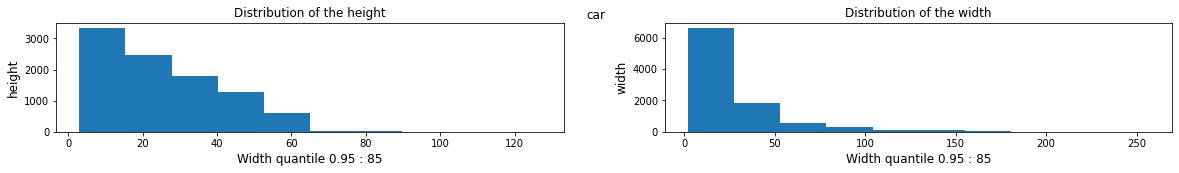

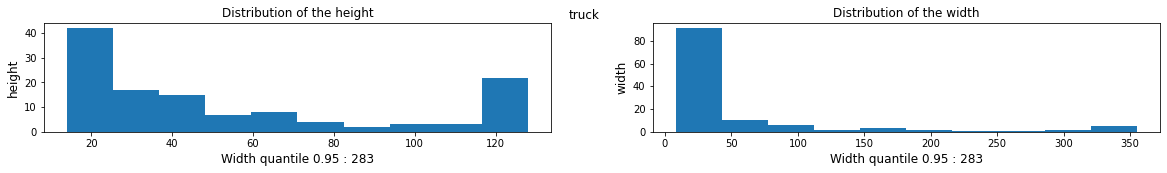

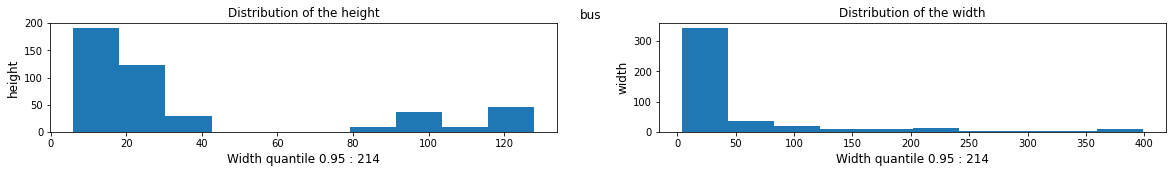

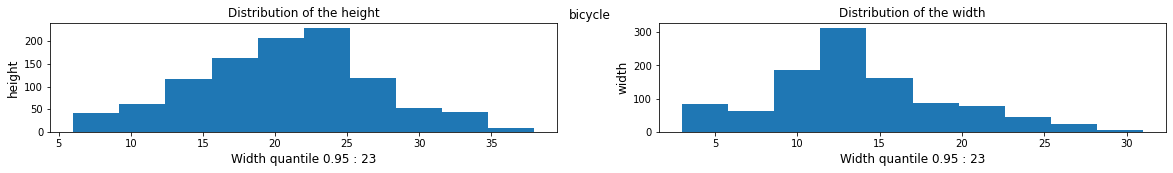

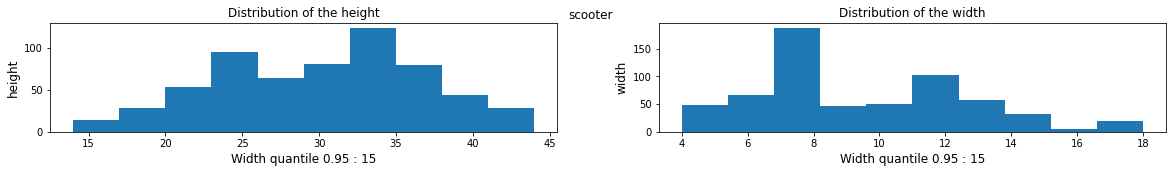

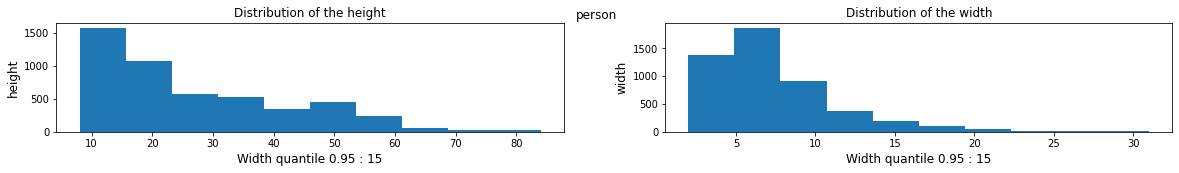

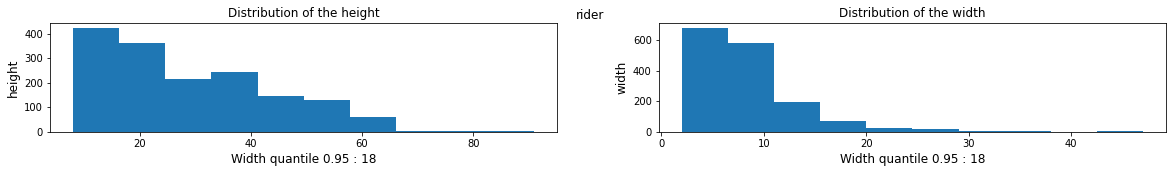

In [17]:
for label in np.sort(boxes.label.unique()):
    label_boxes = boxes[boxes.label == label]

    fig, axs = plt.subplots(1, 2, figsize=[20,2])
    fig.suptitle(tags[label],fontsize=12)
    
    axs[1].hist(label_boxes['width'])
    axs[1].set_title('Distribution of the width',fontsize=12)
    axs[1].set_xlabel("Width quantile 0.95 : " + str(int(label_boxes['width'].quantile(q=0.95))),fontsize=12)
    axs[1].set_ylabel('width',fontsize=12)
    
    axs[0].hist(label_boxes['height'])
    axs[0].set_title('Distribution of the height',fontsize=12)
    axs[0].set_xlabel("Width quantile 0.95 : " + str(int(label_boxes['width'].quantile(q=0.95))),fontsize=12)
    axs[0].set_ylabel('height',fontsize=12)

    plt.show()

In [18]:
sorted(new_anchors, key=lambda x : x[0]*x[1])

[[13, 19], [26, 39], [44, 62], [100, 91], [214, 127], [397, 127]]